#### Необходимо реализовать алгоритм машинного обучения, который позволит по различным параметрам определить место залежей нефти и газа: на суше, на море.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

In [4]:
train_data = pd.read_csv('data for hw_5/train_oil.csv')
test_data = pd.read_csv('data for hw_5/oil_test.csv')
train_data.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [238]:
# train_data.shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

| Поле | Описание |
|------|----------|
| **Field name** | Название месторождения |
| **Reservoir unit** | Юнит месторождения |
| **Country** | Страна расположения |
| **Region** | Регион расположения |
| **Basin name** | Название бассейна пород |
| **Tectonic regime** | Тектонический режим |
| **Latitude** | Широта |
| **Longitude** | Долгота |
| **Operator company** | Название компании |
| **Onshore or offshore** | Целевая переменная (ONSHORE - 1, OFFSHORE - 0, ONSHORE-OFFSHORE - 2) |
| **Hydrocarbon type (main)** | Тип углеводорода |
| **Reservoir status (current)** | Статус месторождения |
| **Structural setting** | Структурные свойства |
| **Depth (top reservoir ft TVD)** | Глубина |
| **Reservoir period** | Литологический период |
| **Lithology (main)** | Литология |
| **Thickness (gross average ft)** | Общая толщина |
| **Thickness (net pay average ft)** | Эффективная толщина |
| **Porosity (matrix average)** | Пористость |
| **Permeability (air average mD)** | Проницаемость |

#### Посмотрим на пропуски в датасете

In [239]:
train_data.isna().sum()

Field name                         0
Reservoir unit                     0
Country                           27
Region                            38
Basin name                        38
Tectonic regime                    0
Latitude                          27
Longitude                         30
Operator company                   0
Onshore/Offshore                   0
Hydrocarbon type                   0
Reservoir status                   0
Structural setting                 0
Depth                              0
Reservoir period                   0
Lithology                          0
Thickness (gross average ft)       0
Thickness (net pay average ft)     0
Porosity                           0
Permeability                       0
dtype: int64

In [240]:
train_data_nan = train_data.loc[:, train_data.isnull().any()]
train_data_nan.isnull().sum() / len(train_data_nan) * 100

Country        8.737864
Region        12.297735
Basin name    12.297735
Latitude       8.737864
Longitude      9.708738
dtype: float64

Заполним числовые колонки `Latitude`, `Longitude` медианными значениями.

In [241]:
num_cols = ['Latitude', 'Longitude']
for col in num_cols:
    if col in train_data.columns:
        # df[col] = pd.to_numeric(df[col])
        train_data[col] = train_data[col].fillna(train_data[col].median())

Переменные типа `object` заполним `Unknown`

In [242]:
obj_cols = ['Country', 'Region', 'Basin name']
for col in obj_cols:
    if col in train_data.columns:
        train_data[col] = train_data[col].fillna('Unknown')

#### Теперь пропусков в train_data нет

In [243]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         309 non-null    object 
 3   Region                          309 non-null    object 
 4   Basin name                      309 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        309 non-null    float64
 7   Longitude                       309 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [244]:
train_data['Country'].unique()

array(['RUSSIA', 'BRAZIL', 'SAUDI ARABIA', 'UK /NORWAY', 'CANADA',
       'UZBEKISTAN', 'USA', 'VENEZUELA', 'Unknown', 'UK', 'INDIA',
       'COLOMBIA', 'THAILAND', 'AUSTRALIA', 'KAZAKHSTAN', 'CHINA',
       'TURKEY', 'FRANCE', 'INDONESIA', 'NORWAY', 'LIBYA', 'ANGOLA',
       'TURKMENISTAN', 'TRINIDAD AND TOBAGO', 'IRAN', 'NEUTRAL ZONE',
       'EGYPT', 'PAPUA NEW GUINEA', 'OMAN', 'ALGERIA', 'GABON', 'QATAR',
       'TUNISIA', 'EQUATORIAL GUINEA', 'TUNISIA /ALGERIA', 'UAE',
       'SOUTH AFRICA', 'DENMARK', 'NIGERIA', 'AFGHANISTAN', 'IRAQ',
       'MALAYSIA', 'NORWAY /UK'], dtype=object)

In [245]:
train_data['Region'].unique()

array(['FORMER SOVIET UNION', 'LATIN AMERICA', 'MIDDLE EAST', 'EUROPE',
       'NORTH AMERICA', 'Unknown', 'FAR EAST', 'AFRICA'], dtype=object)

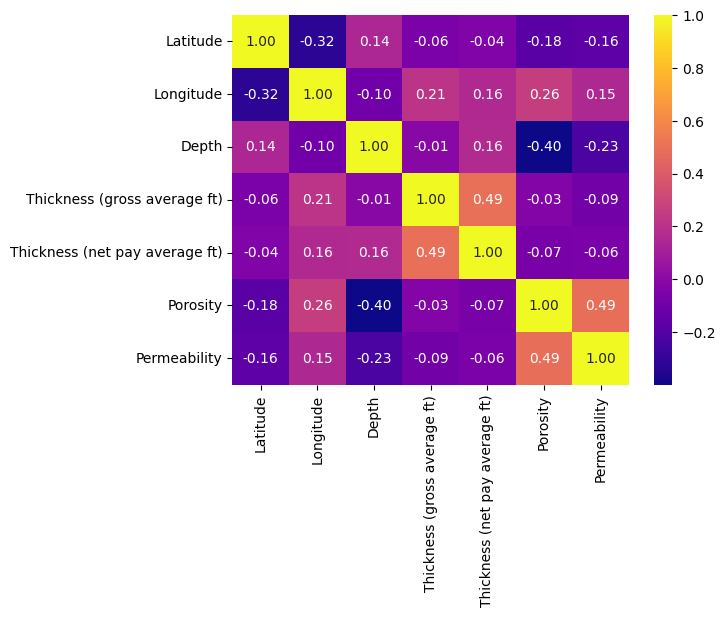

In [6]:
import seaborn as sns
corr_mtrx = train_data.corr(numeric_only= True)
sns.heatmap(corr_mtrx, annot = True, cmap = 'plasma', fmt= '.2f')
plt.show()
# corr_mtrx

#### Закодируем целевую переменную `Onshore/Offshore`

In [9]:
# train_data['Onshore/Offshore'].unique()
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_data['Onshore/Offshore'])
train_data['Onshore/Offshore'] = label_encoder.transform(train_data['Onshore/Offshore'])
train_data.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,1,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,1,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,1,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,0,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,1,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [247]:
columns_to_label_encode = ['Country', 'Region', 'Basin name', 'Operator company']
label_encoders = {}

for col in columns_to_label_encode:
    if col in train_data.columns:
        le = preprocessing.LabelEncoder()
        train_data[col] = le.fit_transform(train_data[col].astype(str))
        label_encoders[col] = le

In [248]:
onehot_columns = ['Tectonic regime', 'Hydrocarbon type', 'Reservoir status', 
                 'Structural setting', 'Reservoir period', 'Lithology']

train_data = pd.get_dummies(train_data, columns = onehot_columns, prefix = onehot_columns)

In [249]:
with pd.option_context('display.max_columns', None):
    display(train_data)

train_data.shape

,Field name,Reservoir unit,Country,Region,Basin name,Latitude,Longitude,Operator company,Onshore/Offshore,Depth,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability,Tectonic regime_COMPRESSION,Tectonic regime_COMPRESSION/EROSION,Tectonic regime_COMPRESSION/EROSION/EXTENSION,Tectonic regime_COMPRESSION/EROSION/EXTENSION/LINKED,Tectonic regime_COMPRESSION/EROSION/GRAVITY/EVAPORITE/EXTENSION,Tectonic regime_COMPRESSION/EVAPORITE,Tectonic regime_COMPRESSION/EVAPORITE/EXTENSION/LINKED,Tectonic regime_COMPRESSION/EVAPORITE/GRAVITY,Tectonic regime_COMPRESSION/EXTENSION,Tectonic regime_COMPRESSION/EXTENSION/EROSION,Tectonic regime_COMPRESSION/EXTENSION/EROSION/EVAPORITE,Tectonic regime_COMPRESSION/EXTENSION/EVAPORITE,Tectonic regime_COMPRESSION/EXTENSION/LINKED,Tectonic regime_COMPRESSION/EXTENSION/LINKED/EROSION,Tectonic regime_COMPRESSION/GRAVITY/EVAPORITE/EXTENSION/LINKED,Tectonic regime_COMPRESSION/SHALE,Tectonic regime_COMPRESSION/SHALE/REACTIVATION/BASEMENT-I,Tectonic regime_COMPRESSION/STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,Tectonic regime_EXTENSION,Tectonic regime_EXTENSION/COMPRESSION,Tectonic regime_EXTENSION/EROSION,Tectonic regime_EXTENSION/EROSION/GRAVITY/EVAPORITE,Tectonic regime_EXTENSION/EVAPORITE,Tectonic regime_EXTENSION/EVAPORITE/EROSION/GRAVITY,Tectonic regime_EXTENSION/EVAPORITE/GRAVITY,Tectonic regime_EXTENSION/EVAPORITE/INVERSION,Tectonic regime_EXTENSION/INVERSION,Tectonic regime_EXTENSION/TRANSTENSION,Tectonic regime_GRAVITY/COMPRESSION/SHALE/EXTENSION/LINKED,Tectonic regime_GRAVITY/EVAPORITE/COMPRESSION,Tectonic regime_GRAVITY/EVAPORITE/EXTENSION,Tectonic regime_GRAVITY/EXTENSION/EVAPORITE,Tectonic regime_GRAVITY/EXTENSION/EVAPORITE/DIAPIR,Tectonic regime_GRAVITY/EXTENSION/EVAPORITE/DIAPIR/SYNSEDIMENTATION,Tectonic regime_GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,Tectonic regime_GRAVITY/EXTENSION/SHALE,Tectonic regime_GRAVITY/EXTENSION/SHALE/SYNSEDIMENTATION,Tectonic regime_GRAVITY/SHALE/EXTENSION,Tectonic regime_GRAVITY/SHALE/EXTENSION/SYNSEDIMENTATION,Tectonic regime_INVERSION/COMPRESSION/EVAPORITE/EROSION,Tectonic regime_INVERSION/COMPRESSION/EXTENSION,Tectonic regime_INVERSION/COMPRESSION/EXTENSION/EROSION,Tectonic regime_INVERSION/COMPRESSION/EXTENSION/EVAPORITE,Tectonic regime_INVERSION/COMPRESSION/EXTENSION/EVAPORITE/GRAVITY,Tectonic regime_INVERSION/COMPRESSION/EXTENSION/SHALE,Tectonic regime_INVERSION/EXTENSION/COMPRESSION,Tectonic regime_INVERSION/STRIKE-SLIP/TRANSPRESSION/EXTENSION/BASEMENT-I,Tectonic regime_STRIKE-SLIP/BASEMENT-I,Tectonic regime_STRIKE-SLIP/INVERSION/COMPRESSION/EXTENSION,Tectonic regime_STRIKE-SLIP/TRANSPRESSION,Tectonic regime_STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,Tectonic regime_STRIKE-SLIP/TRANSTENSION/BASEMENT-I,Tectonic regime_STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEMENT-I,Tectonic regime_TRANSPRESSION/UPLIFT,Tectonic regime_TRANSTENSION/EXTENSION/SHALE/LINKED,Hydrocarbon type_CARBON DIOXIDE,Hydrocarbon type_GAS,Hydrocarbon type_GAS-CONDENSATE,Hydrocarbon type_OIL,Reservoir status_ABANDONED,Reservoir status_CONTINUING DEVELOPMENT,Reservoir status_DECLINING PRODUCTION,Reservoir status_DEPLETED,Reservoir status_DEVELOPING,Reservoir status_MATURE PRODUCTION,Reservoir status_NEARLY DEPLETED,Reservoir status_PLATEAU PRODUCTION,Reservoir status_REJUVENATING,Reservoir status_SECOND PLATEAU PRODUTION,Reservoir status_TEMPORARILY SHUT-IN,Reservoir status_UNDEVELOPED,Reservoir status_UNKNOWN,Structural setting_BACKARC,Structural setting_DELTA/FORELAND,Structural setting_DELTA/PASSIVE MARGIN,Structural setting_DELTA/SALT/PASSIVE MARGIN,Structural setting_DELTA/WRENCH,Structural setting_FORELAND,Structural setting_FORELAND/PASSIVE MARGIN,Structural setting_FORELAND/SALT,Structural setting_FORELAND/THRUST,Structural setting_INTRACRATONIC,Structural setting_INVERSION/BACKARC,Structural setting_INVERSION/FOREARC,Structural setting_INVERSION/FORELAND,Structural setting_INVERSION/RIFT,Structural setting_INVERSION/WRENCH,Structural setting_PASSIVE MARGIN,Stru

(309, 164)

Удалим ненужные колонки для использования модели `LogisticRegression`

In [250]:
X_train = train_data.drop(['Onshore/Offshore', 'Field name', 'Reservoir unit'], axis = 1, errors = 'ignore')
y_train = train_data['Onshore/Offshore']

X_train.fillna(0, inplace = True)

#### Делаем подобную предобработку для test_data

In [251]:
num_cols = ['Latitude', 'Longitude']
for col in num_cols:
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(test_data[col].median())

In [252]:
obj_cols = ['Country', 'Region', 'Basin name']
for col in obj_cols:
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna('Unknown')

In [253]:
columns_to_label_encode = ['Country', 'Region', 'Basin name', 'Operator company']

for col in columns_to_label_encode:
    if col in test_data.columns:
        most_frequent_value = label_encoders[col].classes_[0]
        test_data[col] = test_data[col].astype(str).apply(
            lambda x: x if x in label_encoders[col].classes_ else most_frequent_value
        )
        test_data[col] = label_encoders[col].transform(test_data[col])

In [254]:
test_data = pd.get_dummies(test_data, columns=onehot_columns, prefix=onehot_columns)

In [255]:
for col in X_train.columns:
    if col not in test_data.columns:
        test_data[col] = 0  # добавляем отсутствующие колонки

In [256]:
test_data = test_data[X_train.columns]
X_test = test_data.copy()
X_test.fillna(0, inplace=True)

In [257]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        solver = 'lbfgs',
        max_iter = 2000,
        random_state = 42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(f"Предсказанные классы: {np.unique(y_pred_labels)}")

Предсказанные классы: ['OFFSHORE' 'ONSHORE' 'ONSHORE-OFFSHORE']


In [269]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

model.fit(X_train, y_train_encoded)
y_pred_encoded = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_encoded)
 
submission = pd.DataFrame({
    'index': test_data.index,
    'Onshore/Offshore': y_pred_labels
})
submission.to_csv('predictions.csv', index=False)
submission

,index,Onshore/Offshore
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
128,128,1
129,129,1
130,130,1
131,131,0
